## Script for Projection Catalog
### Setup

In [79]:
import numpy as np
import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from tools.setup.setup import home_dir

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()

import healpy as hp
import fitsio
from tools.setup.setup import tools_home_dir
import pickle

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy import cosmology
from astropy.cosmology import WMAP9 as cosmo #WMAP9 cosmology
from astropy.coordinates import Distance

from tools.setup.setup import data_home_dir, home_dir
import astropy.io.fits as fits

# setup notebook for inline figures
%matplotlib inline

#file containing the rotation matrix 
toolsdir = tools_home_dir()
rotfile = toolsdir+'desy3_irot.pkl'
with open(rotfile, 'r') as fp:
    rmat = pickle.load(fp)
    
import pkg_resources
pkg_resources.get_distribution("astropy").version

'2.0.10'

### Projection catalog
#### Add X,Y,Z columns into the projection catalog

The Cartesian (X,Y,Z) are in units of Mpc/h when converting from spherical using the SkyCoord function and distance taken from comving_distane. h0 is given by user under e.g. WMAP9 cosmology. 

Buzzard halos coordinates are in units of Mpc, not Mpc/h.

In [20]:
datadir = data_home_dir()
homedir = home_dir()
proj_dir = datadir + 'projection/'+'mock_SDSS_PlM_logNorm_lM_Simet_lobg5.fit'
proj_list = fits.open(proj_dir)
proj_data = proj_list[1].data

#Convert RA, DEC to Cartesian coordinates
h0 = cosmo.H(0).value/100.#Reduced Hubble constant

proj_dist = cosmo.comoving_distance(proj_data.Z_TR) #In units of Mpc/h
c = SkyCoord(ra=proj_data.RA*u.degree, dec=proj_data.DEC*u.degree, distance=proj_dist, frame='icrs')
proj_X = c.cartesian.x.value #in units of Mpc/h
proj_Y = c.cartesian.y.value
proj_Z = c.cartesian.z.value

#Are the units in Mpc, or in Mpc/h? This figure out. 
#proj_X /= h0
#proj_Y /= h0
#proj_Z /= h0

#Add X,Y,Z
c1 = fits.Column(name='proj_X', array=proj_X, format='E') #E is single float precision, D for double. 
c2 = fits.Column(name='proj_Y', array=proj_Y, format='E')
c3 = fits.Column(name='proj_Z', array=proj_Z, format='E')
newcols = [c for c in proj_list[1].columns] + [c1, c2, c3]
tnew = fits.BinTableHDU.from_columns(newcols)
proj_list[1] = tnew

#proj_list.writeto('projection.fits')
#print "Wrote FITS with added columns onto new FITS file."

#Extract data
proj_data = proj_list[1].data
#Checking FITS into
#hrun_list.info()
print "Names of columns in proj_data are:"
print proj_data.names

#Converting FITS files into record array
proj_data = np.array(proj_data, dtype=proj_data.dtype)
proj_data = proj_data.view(np.recarray)

print "Number of halos is", len(proj_data)

#Filter out Lambda < 10
lmda_cut = np.where(proj_data['LAMBDA_OB'] >= 10)
proj_data = proj_data[lmda_cut]
proj_dist = proj_dist[lmda_cut]

print "Number of halos after lambda cut is", len(proj_data)

Names of columns in proj_data are:
['M200', 'Z_TR', 'Z_OB', 'RA', 'DEC', 'LAMBDA_TR', 'LAMBDA_OB', 'proj_X', 'proj_Y', 'proj_Z']
Number of halos is 668152
Number of halos after lambda cut is 358471


### redM_matched Halos

In [5]:
#RedM_matched halos
#Read from redM_matched halos
homedir = home_dir()
redM_dir = homedir + 'output/buzzard/'+'halo_redM_matched.dat'

#Field names of the files from first row of file. Shoule be:
#('redM_ID', 'redM_RA', 'redM_DEC', 'redM_z', 'redM_lmda', 'halos_ID', 'halos_RA', 'halos_DEC', 
#'halos_z', 'halos_X', 'halos_Y', 'halos_Z', 'halos_M200b', 'halos_Mvir', 'halos_Rvir')
redM_halos = np.genfromtxt(redM_dir, dtype ="i, f8, f8, f8, f8, i, f8, f8, f8, f8, f8, f8, f8, f8, f8", \
                  unpack=True, usecols=range(0,15), names=True)
redM_halos = redM_halos.view(np.recarray)

print "Names of redM_matched halo column data are:"
print redM_halos.dtype.names, "\n"
print "Number of halos read is ", len(redM_halos)

Names of redM_matched halo column data are:
('redM_ID', 'redM_RA', 'redM_DEC', 'redM_z', 'redM_lmda', 'halos_ID', 'halos_RA', 'halos_DEC', 'halos_z', 'halos_X', 'halos_Y', 'halos_Z', 'halos_M200b', 'halos_Mvir', 'halos_Rvir') 

Number of halos read is  23998


### Buzzard halos

In [6]:
buzzard_dir = datadir + 'buzzard_halo/chinchilla/' + 'Chinchilla-0_halos_all.fits'
buzz_list = fits.open(buzzard_dir)
buzz_data = buzz_list[1].data

#Checking FITS into
print "Names of columns in buzz_data are:"
print buzz_data.names

#Converting FITS files into record array
buzz_data = np.array(buzz_data, dtype=buzz_data.dtype)
buzz_data = buzz_data.view(np.recarray)
buzz_dist = cosmo.comoving_distance(buzz_data.Z)

print "\nNumber of halos is", len(buzz_data)

Names of columns in buzz_data are:
['ID', 'DESCID', 'MVIR', 'VMAX', 'VRMS', 'RVIR', 'RS', 'NP', 'PX', 'PY', 'PZ', 'VX', 'VY', 'VZ', 'JX', 'JY', 'JZ', 'SPIN', 'RS_KLYPIN', 'MVIR_ALL', 'M200B', 'M200C', 'M500C', 'M2500C', 'XOFF', 'VOFF', 'SPIN_BULLOCK', 'B_TO_A', 'C_TO_A', 'PID', 'LUMTOT', 'LUM20', 'LBCG', 'NGALS', 'N18', 'N19', 'N20', 'N21', 'N22', 'Z', 'RA', 'DEC']

Number of halos is 12198813


### Halo_shape catalog

In [72]:
from repo.halo_shape.read_shape_param import read_shape_param

filename = 'halo_shape_rand_allz.npy'
shapedir = home_dir()+'output/buzzard/halo_shape/'
halo_shape = np.load(shapedir+filename)
shape_ID, q, s, cos_i = read_shape_param(halo_shape, convcut=True)
print "Number of halos in halo_shape is ", len(shape_ID) 

Number of halos in halo_shape is  54203


In [52]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind = halo_bin_stat(cos_i, cosi_bins)

### Matching Projection Catalog with Chinchilla halos
* Note: astropy.comoving in units of Mpc/h 

Things to do
* Using a proximity matching algorithm match the projection catalog with Chinchilla in units of Mpc/h using the comoving_distance function

#### Checking consistency of parameters in catalogs

In [15]:
#Sort halos by mass, and see if the most massive ones have matching properties. 
proj_sortind = np.argsort(proj_data.M200)
proj_indmax = proj_sortind[-1]
print proj_sortind
print proj_data.M200[proj_sortind]
print '\nTesting properties of largest halo in Projection Catalog'
print proj_data.dtype.names
print proj_data[proj_indmax]

#For the Chinchilla catalog. 
print '\nTesting the Chinchilla catalog'
buzz_sortind = np.argsort(buzz_data.M200B)
buzz_indmax = buzz_sortind[-1]
print buzz_data.dtype.names
buzz_maxM = buzz_data[buzz_indmax]
print buzz_maxM

print proj_data[proj_indmax].proj_X*h0, proj_data[proj_indmax].proj_Y*h0, proj_data[proj_indmax].proj_Z*h0, '\n'

#Find comoving distance of Chinchilla and cf. with Pythagoreous
print buzz_dist[buzz_indmax]*h0
print np.sqrt(buzz_maxM.PX**2. + buzz_maxM.PY**2. +  buzz_maxM.PZ**2.)

[ 51954  73901   3846 ...  26153 147129 115247]
[1.0013e+13 1.0013e+13 1.0013e+13 ... 2.3066e+15 2.5839e+15 3.3991e+15]

Testing properties of largest halo in Projection Catalog
('M200', 'Z_TR', 'Z_OB', 'RA', 'DEC', 'LAMBDA_TR', 'LAMBDA_OB', 'proj_X', 'proj_Y', 'proj_Z')
(3.3991e+15, 0.38548893, 0.37671077, 148.0982, 59.208557, 279.9802, 396.04456, -661.15247, 411.56, 1306.8656)

Testing the Chinchilla catalog
('ID', 'DESCID', 'MVIR', 'VMAX', 'VRMS', 'RVIR', 'RS', 'NP', 'PX', 'PY', 'PZ', 'VX', 'VY', 'VZ', 'JX', 'JY', 'JZ', 'SPIN', 'RS_KLYPIN', 'MVIR_ALL', 'M200B', 'M200C', 'M500C', 'M2500C', 'XOFF', 'VOFF', 'SPIN_BULLOCK', 'B_TO_A', 'C_TO_A', 'PID', 'LUMTOT', 'LUM20', 'LBCG', 'NGALS', 'N18', 'N19', 'N20', 'N21', 'N22', 'Z', 'RA', 'DEC')
(115444861, -1, 3.2463e+15, 2496.66, 2399.8, 3396.857, 872.196, 10099., -463.0979, 288.29492, 915.4397, 473.2, -266.11, -13.03, -4.375e+17, -6.957e+17, 2.044e+17, 0.03042, 773.45215, 3.2463e+15, 3.403e+15, 2.8979e+15, 1.7697e+15, 5.7837e+14, 342.71368, 

In [23]:
#Astropy has coordinate matching algorithm
#http://docs.astropy.org/en/stable/coordinates/matchsep.html

print proj_data.RA*u.degree, len(proj_data.RA*u.degree)
print proj_dist.value*u.Mpc, len(proj_dist.value*u.Mpc)

#Find distances to the catalog from redshift using WMAP9 cosmology
proj_c = SkyCoord(ra=proj_data.RA*u.degree, dec=proj_data.DEC*u.degree, distance=proj_dist.value*u.Mpc)  
buzz_c = SkyCoord(ra=buzz_data.RA*u.degree, dec=buzz_data.DEC*u.degree, distance=buzz_dist.value*u.Mpc) 

#For c.match_to_catalog_3d(catalog), c should be a subset of catalog.
idx, d2d, d3d = proj_c.match_to_catalog_3d(buzz_c) 
z_diff = proj_data.Z_TR - buzz_data.Z[idx]

[160.94777  161.2746   161.04921  ...  26.72795   27.703318  27.453608] deg 358471
[ 965.87340436  960.11768555  975.47765464 ... 2170.33580157 2189.11915568
 2199.74737629] Mpc 358471


### Apply cuts to matched catalog

In [88]:
print "Number of matched halos are ", len(idx)
uniq_idx, uniq_index = np.unique(idx, return_index=True)
idx = idx[uniq_index]; d2d = d2d[uniq_index]; d3d = d3d[uniq_index]
print "Out of which ", len(idx), " are unique"
buzz_data_matched = buzz_data[idx]

#Apply 
mass_cutoff = buzz_data_matched['M200B'] > 1e13
buzz_data_matched = buzz_data_matched[mass_cutoff]

print "After mass cut of M > 1e13 M_sun number of halos is ", len(buzz_data_matched)

Number of matched halos are  324178
Out of which  324178  are unique
After mass cut of M > 1e13 M_sun number of halos is  135272


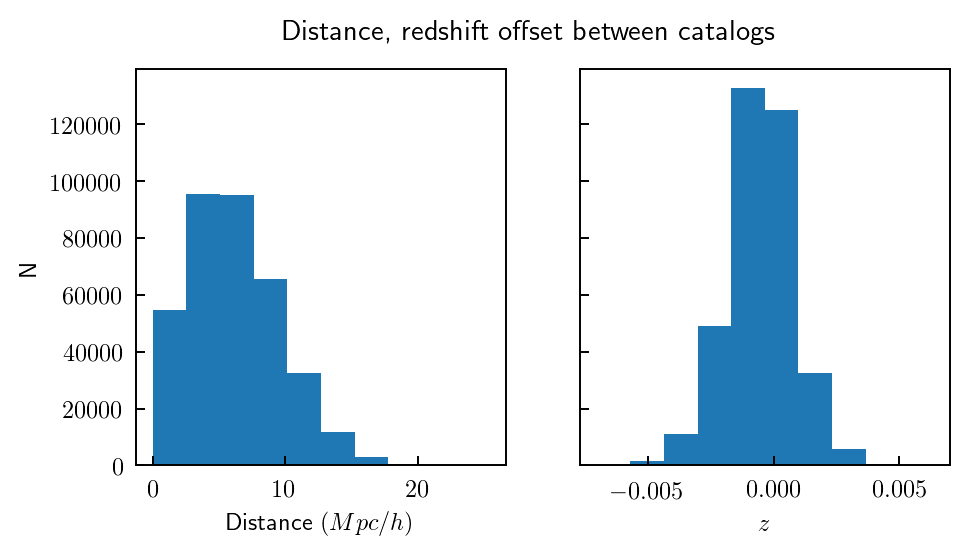

In [44]:
#Seeing the offset in distance, redshift after catalog matching
f, ax = plt.subplots(1,2, sharey=True, figsize=(6,3))
f.suptitle('Distance, redshift offset between catalogs')
ax[0].hist(d3d.value)
ax[0].set_xlabel('Distance $(Mpc/h)$')
ax[1].hist(z_diff)
ax[1].set_xlabel('$z$')
ax[0].set_ylabel(r'N')
plt.show()

In [93]:
#Write projection ID to file
#Write to file
outfile = homedir +'data/projection/proj_ID' #save as npy file
np.save(outfile, buzz_data_matched.ID)

In [71]:
#Match Chinchilla IDs onto the Projection halos
#Then bin the Projection halos by cos(i)
#We will need to import the cos(i) shape catalog and match the IDs of the projection onto the shape catalog. 

2483
36445


### Halo orientation catalog from halo run

In [7]:
#Rotate the halo files
import healpy as hp
import fitsio
from tools.setup.setup import tools_home_dir
import pickle

from astropy import units as u
from astropy.coordinates import SkyCoord


#file containing the rotation matrix 
toolsdir = tools_home_dir()
rotfile = toolsdir+'desy3_irot.pkl'
with open(rotfile, 'r') as fp:
    rmat = pickle.load(fp)

[-0.9427562  -0.94396466 -0.9427364  ...  0.8730384   0.84763545
  0.85006094]


In [29]:
#Convert RA, DEC to Cartesian coordinates
from astropy import cosmology
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import Distance

#proj_dist = cosmo.comoving_distance(proj_data.Z_TR)
c = SkyCoord(ra=proj_data.RA*u.degree, dec=proj_data.DEC*u.degree, distance=proj_dist, frame='icrs')
proj_X = c.cartesian.x.value #in units of Mpc
proj_Y = c.cartesian.y.value
proj_Z = c.cartesian.z.value

##????
#Are the units in Mpc, or in Mpc/h? This figure out. 

In [30]:
proj_posvec = np.array([proj_X, proj_Y, proj_Z])
proj_rposvec = np.dot(rmat, halos_posvec)

#Rotate the Cartesian positions.
proj_X = halos_rposvec[0]; proj_Y = halos_rposvec[1]; proj_Z = halos_rposvec[2]
#convert to angular coords (in Radians)
theta, phi = hp.vec2ang(proj_rposvec.T)
proj_data['DEC'] = (np.pi/2 - theta) * 180/np.pi
proj_data['RA'] = phi * 180/np.pi
proj_DEC = proj_data['DEC']
proj_RA = proj_data['RA']
#print 'Halos DEC and RA \n', halos_data['DEC'], '\n', halos_data['RA']

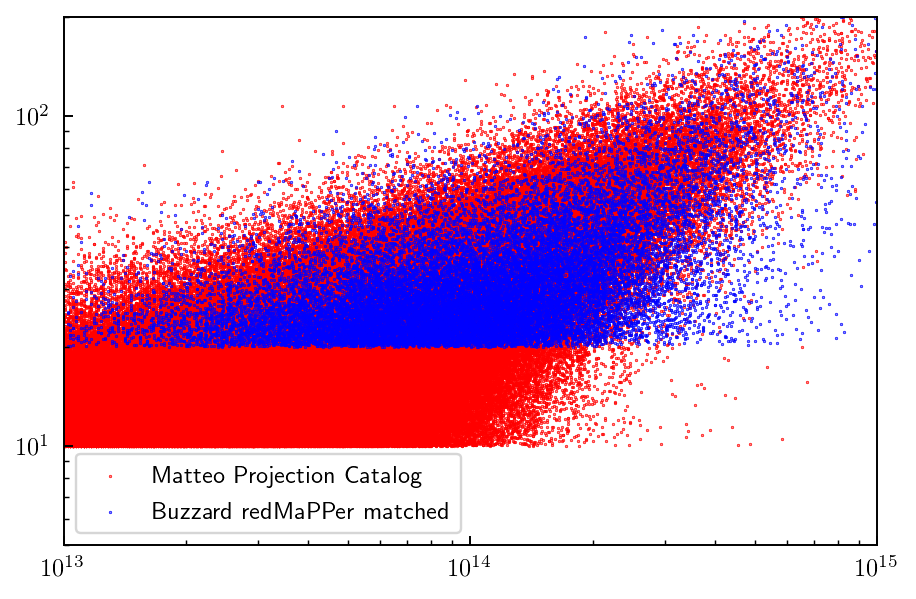

In [50]:
plt.scatter(proj_data['M200'], proj_data['LAMBDA_OB'], s =0.1, color='r', label='Matteo Projection Catalog')
plt.scatter(redM_halos['halos_M200b'], redM_halos['redM_lmda'], s =0.1, color='b', label='Buzzard redMaPPer matched')
plt.xscale('log'); plt.yscale('log')
plt.xlim([1e13,1e15])
plt.ylim([5,200])
plt.legend()
plt.show()